# Mapk Counterfactual Inference

In [1]:
import sys
sys.path.append('../')

import pyro
from pyro import sample
from pyro.distributions import Normal, Uniform
import torch
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import pyro.optim

from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import NUTS, HMC
from pyro.infer import EmpiricalMarginal

from mapk_demon.inference import infer_dist
from mapk_demon.receivers import mapk_receiver, mapk_companion, mapk_do_receiver

import matplotlib.pyplot as plt
%matplotlib inline

pyro.set_rng_seed(101)
sample_size = 1000

def hist(marginal, name):
    plt.hist([marginal() for _ in range(5000)])
    plt.title("Marginal Histogram of {}".format(name))
    plt.xlabel("concentration")
    plt.ylabel("#")

Let $$N_{3k}, N_{2k}, N_k \sim Normal\ (10, 1)$$.

In [3]:
noise_vars = ['N_3k', 'N_2k', 'N_k']
noise_dists = {N: Normal(10., 1.) for N in noise_vars}

evidence = mapk_receiver(noise_dists)

## 1. Condition the model on observed map3k, map2k, mapk

In [4]:
conditioned_mapk = pyro.condition(mapk_companion, data=evidence)

## 2. Infer the noise distributions N_3k, N_2k, N_k from companion model

Let there be a prior over Noise distributions. $$N_{3k}, N_{2k}, N_k \sim Normal\ (0, 1)$$.

I have used HMC and MCMC for inference.

In [5]:
noise_priors = {N: Normal(0., 1.) for N in noise_vars}

posterior = infer_dist(conditioned_mapk, noise_priors)

noise_marginals = {
    n: EmpiricalMarginal(posterior, sites=n)
    for n in noise_vars
}

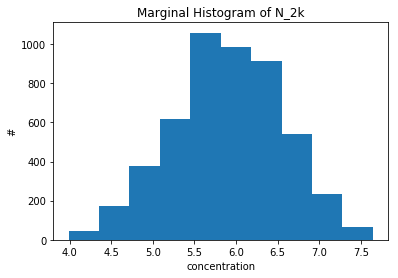

In [6]:
hist(noise_marginals['N_2k'], 'N_2k')

## 3. do Map3k = 0.678

In [12]:
do_map3k = pyro.do(mapk_companion, data={'map3k': torch.tensor(50000.678)})

## 4. Infer Mapk

In [13]:
# Deriving mean and std by sampling from marginals
noise_posterior_mean = {
    n: torch.stack([noise_marginals[n]() for _ in range(5000)]).mean()
    for n in noise_vars
}
noise_posterior_std = {
    n: torch.stack([noise_marginals[n]() for _ in range(5000)]).std()
    for n in noise_vars
}

noise_posteriors = {
    n: Normal(noise_posterior_mean[n], noise_posterior_std[n])
    for n in noise_vars
}

mapk_do_dist = infer_dist(do_map3k, noise_posteriors)

mapk_marginal = EmpiricalMarginal(mapk_do_dist, sites='map2k')

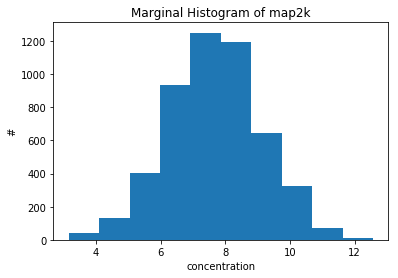

In [14]:
hist(mapk_marginal, 'map2k')

In [16]:
torch.stack([mapk_do_receiver(0.678, noise_posteriors)]*1000).mean()

tensor(7.7734)